In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SSF/BX-Users.csv",sep=";", encoding='utf-8')
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SSF/BX-Book-Ratings.csv",sep=";", encoding="unicode_escape")
books = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SSF/BX-Books.csv",sep = ';', escapechar='\\', encoding='UTF-8')

# Limpieza de Users

In [ ]:
print("Users shape: " + str(users.shape))
print("User types: \n" + str(users.dtypes))
print("User types: \n" + str(users.columns))
print("Users head: \n" + str(users.head()) +"\n")

Users shape: (278858, 3)
User types: 
User-ID       int64
Location     object
Age         float64
dtype: object
User types: 
Index(['User-ID', 'Location', 'Age'], dtype='object')
Users head: 
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN



Limpio la tabla de usuarios eliminando:
*   Usuarios cuyo ID no esté  entre 1 y 278858
*   Registros con ID duplicados
Indexo la tabla con User-ID

In [ ]:
users_before = users.shape[0]
users.where((users["User-ID"]>=1) & (users["User-ID"]<=278858), inplace=True)
users.drop_duplicates(subset ="User-ID", keep = False, inplace = True)
users.set_index("User-ID",inplace=True)

In [ ]:
print("Usuarios eliminados:\n"+ str(users_before - users.shape[0] )+" usuarios")

Usuarios eliminados:
0 usuarios


Separo la columna location usando ',' como separador. <br>
Guardo cada campo en columnas diferentes.<br>
Limpio de nuevo la tabla users, eliminando líneas que contengan los siguientes caracteres en la columna "Country":
*   Vacío
*   "
*   .
*   ;
*   ,

In [ ]:
users_before = users.shape[0]
location = users["Location"].str.split(pat=",",n=2,expand=True,).fillna('')
users["City"] = location[0]
users["Region"] = location[1]
users["Country"] = location[2]
users.drop(['Location'], axis=1,inplace=True)
users = users[~users["Country"].str.contains(r'^$|\"|\.|;|,')]
print(users)

          Age         City            Region          Country
User-ID                                                      
1         NaN          nyc          new york              usa
2        18.0     stockton        california              usa
3         NaN       moscow   yukon territory           russia
4        17.0        porto          v.n.gaia         portugal
5         NaN  farnborough             hants   united kingdom
...       ...          ...               ...              ...
278854    NaN     portland            oregon              usa
278855   50.0       tacoma        washington   united kingdom
278856    NaN     brampton           ontario           canada
278857    NaN    knoxville         tennessee              usa
278858    NaN       dublin               n/a          ireland

[272062 rows x 4 columns]


In [ ]:
print("Usuarios eliminados:\n"+ str(users_before - users.shape[0] )+" usuarios")

Usuarios eliminados:
6796 usuarios


Si el valor de "Age" es inferior a 12 o superior a 100, lo hago nulo. <br>
Luego lleno los valores vacíos con el valor 0.  

In [ ]:
users.loc[users["Age"] > 100, "Age"] = None
users.loc[users["Age"] < 12, "Age"] = None
users['Age'] = users['Age'].fillna(0).astype(int) 

# Limpieza de Ratings

In [ ]:
print("Ratings shape: " + str(ratings.shape)+"\n")
print("Ratings types:\n " + str(ratings.dtypes)+"\n")
print("Ratings head: \n" + str(ratings.columns)+"\n")
print("Ratings head: \n" + str(ratings.head())+"\n")

Ratings shape: (1149780, 3)

Ratings types:
 User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

Ratings head: 
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

Ratings head: 
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6



Modifico los ISBN, quitando caracteres no alphanuméricos<br>
Limpio la tabla de ratings eliminando:
*   Ratings cuyo User-ID no esté  entre 1 y 278858
*   Líneas duplicadas
*   Líneas cuyo Book-Ratings no esté entre 0 y 10 <br>

In [ ]:
ratings_before = ratings.shape[0]
ratings.drop_duplicates(keep = False, inplace = True)
ratings["ISBN"] = ratings["ISBN"].str.replace(r'[^\w\d]+', '')
ratings.where((ratings["Book-Rating"]>=0) & (ratings["Book-Rating"]<=10), inplace=True)
ratings.where((ratings["User-ID"]>=1) & (ratings["User-ID"]<=278858), inplace=True)

In [ ]:
print("Ratings eliminados: "+str(ratings_before - ratings.shape[0])+" ratings")

Ratings eliminados: 0 ratings


#Limpieza de Books

In [ ]:
print("Books shape: " + str(books.shape)+"\n")
print("Books types:\n " + str(books.dtypes)+"\n")
print("Books head: \n" + str(books.columns)+"\n")
print("Books head: \n" + str(books.head())+"\n")

Books shape: (271379, 8)

Books types:
 ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

Books head: 
Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

Books head: 
         ISBN  ...                                        Image-URL-L
0  0195153448  ...  http://images.amazon.com/images/P/0195153448.0...
1  0002005018  ...  http://images.amazon.com/images/P/0002005018.0...
2  0060973129  ...  http://images.amazon.com/images/P/0060973129.0...
3  0374157065  ...  http://images.amazon.com/images/P/0374157065.0...
4  0393045218  ...  http://images.amazon.com/images/P/0393045218.0...

[5 rows x 8 columns]



Boto las columnas de imagenes de la tabla Books. <br>
Luego, elimino líneas con ISBN duplicados y limpio el ISBN de la misma manera que para Ratings<br>
Por último, indexo la tabla books por el ISBN

In [ ]:
books.drop(["Image-URL-S","Image-URL-M","Image-URL-L"],inplace=True, axis=1)
books.drop_duplicates(subset ="ISBN", keep = "first", inplace = True)
books["ISBN"] = books["ISBN"].str.replace(r'[^\w\d]+', '')
books.set_index(["ISBN"], inplace=True)

Remplazo el año de publicación por 0 si el año es superior a 2004

In [ ]:
books.loc[books['Year-Of-Publication'] > 2004, 'Year-Of-Publication'] = 0

# Reducción de dimension

Elimino usuarios que no hayan dejado ratings

In [ ]:
users_before = users.shape[0]
users = users[users.index.isin(ratings["User-ID"])]

In [ ]:
print("Users eliminados: "+str(users_before - users.shape[0])+" users")

Users eliminados: 170642 users


Elimino ratings de libros que no estén en la tabla books

In [ ]:
ratings_before = ratings.shape[0]
ratings = ratings[ratings["ISBN"].isin(books.index)]

In [ ]:
print("Ratings eliminados: "+str(ratings_before - ratings.shape[0])+" ratings \n")

Ratings eliminados: 118269 ratings 



# Plots y stats

<u>Usuarios por edad</u>

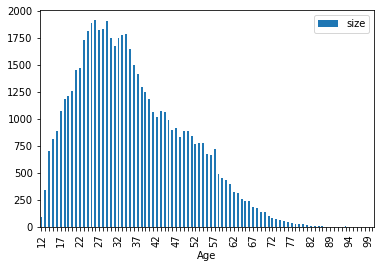

25% de los usuarios tiene entre 12 y 25 años

50% de los usuarios tiene entre 12 y 33 años

75% de los usuarios tiene entre 12 y 45 años

50% de los usuarios tiene entre 25 y 45 años

La mayoría de usuarios (1918) tienen 26 años 

Edad promedio: 36 años
Usuarios que no ingresaron su edad: 41643 (41% de los usuarios)


In [ ]:
age_by_user = users.where(users['Age']>0).groupby(["Age"] ,as_index=False).size().astype(int)
ax = age_by_user.plot(x='Age', y='size', kind="bar")
every_nth = 5

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

ages_quartiles = users[users['Age']>0].quantile([0.25,0.5,0.75])['Age'].values
print("25% de los usuarios tiene entre 12 y " +str(int(ages_quartiles[0])) + ' años\n')
print("50% de los usuarios tiene entre 12 y " +str(int(ages_quartiles[1])) + ' años\n')
print("75% de los usuarios tiene entre 12 y " +str(int(ages_quartiles[2])) + ' años\n')
print("50% de los usuarios tiene entre "+str(int(ages_quartiles[0]))+" y " +str(int(ages_quartiles[2])) + ' años\n')
print("La mayoría de usuarios ("+str(age_by_user['size'].max())+") tienen "+ str(age_by_user[age_by_user['size'] == age_by_user['size'].max()]['Age'].values[0])+" años \n")
print("Edad promedio: " + str(round(users[users['Age']>0].mean().values[0]))+" años")
print("Usuarios que no ingresaron su edad: " + str(users[users['Age']==0].shape[0]) + " ("+str(round(users[users['Age']==0].shape[0]*100/users.shape[0]))+"% de los usuarios)")

<u>Usuarios por país</u>

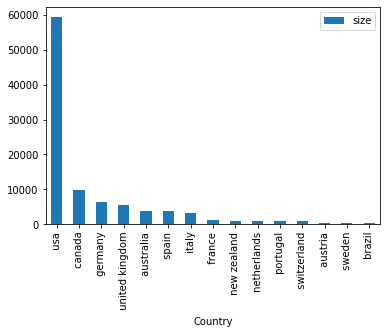

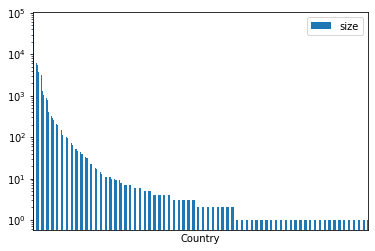

La mayoría de usuarios (59%) viven en  usa 

75% de los usuarios viven en 3 paises


In [ ]:
users_by_country = users.groupby(["Country"], as_index=False).size()
users_by_country.sort_values(by=["size"], ascending=False).head(15).plot(x='Country', y='size', kind="bar")
plt.show()

ax = users_by_country.sort_values(by=["size"], ascending=False).plot(x='Country', y='size', kind="bar")
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()

print("La mayoría de usuarios ("+str( round(users_by_country['size'].max()/users.shape[0]*100) )+"%) viven en "+ str(users_by_country[users_by_country['size'] == users_by_country['size'].max()]['Country'].values[0])+" \n")
print(str(round( (users_by_country[users_by_country['Country'] == ' usa']['size'].values[0] + users_by_country[users_by_country['Country'] == ' canada']['size'].values[0]+ users_by_country[users_by_country['Country'] == ' germany']['size'].values[0])/users.shape[0]*100 ))+ "% de los usuarios viven en 3 paises" )


<u>Ratings por libro</u>

95% de los libros tienen menos de 12.0 ratings
Un libro tiene en promedio 4 ratings
Max: 2502


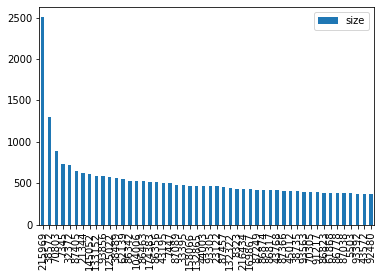

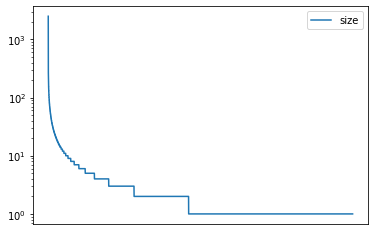

In [ ]:
reviews_count = ratings.groupby(['ISBN'],as_index=False).size()
reviews_count.sort_values(by=["size"], ascending=False).head(50).plot(y='size', kind="bar")
ax = reviews_count.sort_values(by=["size"], ascending=False).plot(use_index=False,y='size', kind="line")
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)

plt.plot()

centiles = reviews_count.quantile([.95])
print("95% de los libros tienen menos de "+str(centiles.iloc[0]['size'])+ " ratings")
print("Un libro tiene en promedio "+ str(round(reviews_count['size'].mean()))+" ratings")
print("Max: "+str(reviews_count['size'].max()))

<u>Usuarios por rating</u>

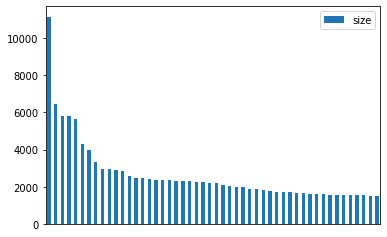

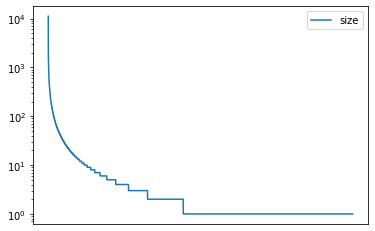

75% de los usuarios han dejado 4.0 ratings o menos
Max: 11153


In [ ]:
users_by_rating = ratings.groupby(['User-ID'], as_index=False).size()
users_by_rating.sort_values(by=['size'],ascending=False).head(50).plot(y='size', kind="bar")
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
ax = users_by_rating.sort_values(by=['size'],ascending=False).plot(use_index=False, y='size',kind="line")
ax.set_yscale('log')
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()
users_by_rating_centiles = users_by_rating.quantile([.75])
print("75% de los usuarios han dejado "+str(users_by_rating_centiles.iloc[0]['size'])+ " ratings o menos")
print("Max: " +str(users_by_rating['size'].max()))

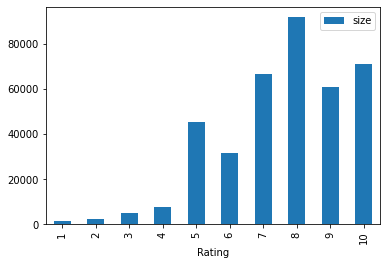

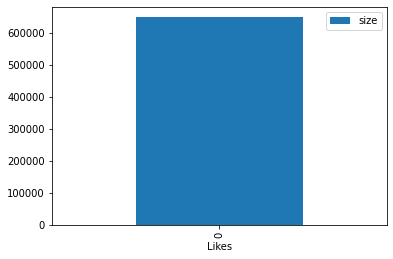

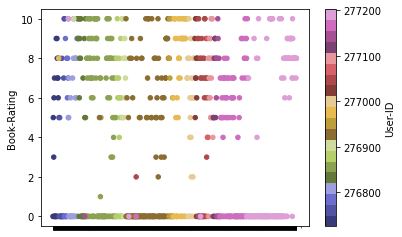

Media ponderada: 7.63

Hay 647476 likes
63% de los ratings son likes


In [ ]:
ratings_by_users = ratings.groupby(['Book-Rating'], as_index=False).size()
ratings_by_users[ratings_by_users['Book-Rating']>0].sort_values(by=['Book-Rating'],ascending=True).plot(xlabel="Rating",y='size', kind="bar")
ratings_by_users[ratings_by_users['Book-Rating']==0].sort_values(by=['Book-Rating'],ascending=True).plot( xlabel="Likes", y='size', kind="bar")
ratings.head(1000).plot.scatter(x="ISBN",y="Book-Rating", c='User-ID', colormap='tab20b',ylabel="Rating")
plt.show() 

print("Media ponderada: "+str( round((ratings_by_users[ratings_by_users["Book-Rating"]!=0]["Book-Rating"] * ratings_by_users[ratings_by_users["Book-Rating"]!=0]["size"]).sum() / ratings_by_users[ratings_by_users["Book-Rating"]!=0]["size"].sum(),2))+"\n")
print("Hay "+str(ratings_by_users[ratings_by_users['Book-Rating']==0]["size"].values[0])+" likes")
print(str(round(ratings_by_users[ratings_by_users['Book-Rating']==0]["size"].values[0]*100/ratings_by_users['size'].sum()))+"% de los ratings son likes")

<u>Libros con más ratings</u>

In [ ]:
print("Top 10 libros con más ratings: ")
top_books_isbn = reviews_count.sort_values(by=['size'],ascending=False).head(10)['ISBN'].values.tolist()
print(books.loc[top_books_isbn,["Book-Title","Book-Author"]])

Top 10 libros con más ratings: 
                                                   Book-Title     Book-Author
ISBN                                                                         
0971880107                                        Wild Animus    Rich Shapero
0316666343                          The Lovely Bones: A Novel    Alice Sebold
0385504209                                  The Da Vinci Code       Dan Brown
0060928336    Divine Secrets of the Ya-Ya Sisterhood: A Novel   Rebecca Wells
0312195516                The Red Tent (Bestselling Backlist)   Anita Diamant
044023722X                                    A Painted House    John Grisham
0142001740                            The Secret Life of Bees   Sue Monk Kidd
067976402X                             Snow Falling on Cedars  David Guterson
0671027360                                Angels &amp; Demons       Dan Brown
0446672211  Where the Heart Is (Oprah's Book Club (Paperba...    Billie Letts


<u>Libros con mejores ratings</u>

In [ ]:
print("Top 10 libros con mejores ratings: ")
best_rated_books_isbn=ratings.groupby(["Book-Rating"],as_index=False).get_group(10).groupby(['ISBN'],as_index=False).size().sort_values(by=['size'], ascending=False)['ISBN'].values   
if len(best_rated_books_isbn)>=10:
    best_rated_books_isbn = best_rated_books_isbn[0:10]
else:
    raise Exception("10 rated group is too small, code something else")
    
print(books.loc[best_rated_books_isbn,["Book-Title","Book-Author"]])

Top 10 libros con mejores ratings: 
                                                   Book-Title    Book-Author
ISBN                                                                        
0385504209                                  The Da Vinci Code      Dan Brown
059035342X  Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling
0316666343                          The Lovely Bones: A Novel   Alice Sebold
043935806X  Harry Potter and the Order of the Phoenix (Boo...  J. K. Rowling
0446310786                              To Kill a Mockingbird     Harper Lee
0312195516                The Red Tent (Bestselling Backlist)  Anita Diamant
0142001740                            The Secret Life of Bees  Sue Monk Kidd
0439139597       Harry Potter and the Goblet of Fire (Book 4)  J. K. Rowling
0439136350  Harry Potter and the Prisoner of Azkaban (Book 3)  J. K. Rowling
0385484518  Tuesdays with Morrie: An Old Man, a Young Man,...    MITCH ALBOM


<u>Libros por año de publicación</u>

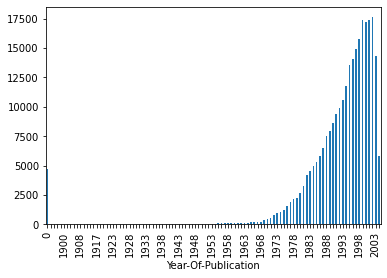

80% de los libros fueron publicados entre 1982 y 2002
Libros sin año registrado:4691 (2%)


In [ ]:
books_by_year = books.groupby(["Year-Of-Publication"]).size()
ax = books_by_year.plot(xlabel="Year-Of-Publication",y='size', kind="bar")
every_nth = 5

for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()
books_by_year_centiles = books['Year-Of-Publication'].quantile([0.1,0.9])
print("80% de los libros fueron publicados entre "+str(int(books_by_year_centiles.values[0]))+" y "+str(int(books_by_year_centiles.values[1])))
print("Libros sin año registrado:"+str(books[books["Year-Of-Publication"]==0].shape[0])+" ("+str(round(books[books["Year-Of-Publication"]==0].shape[0]*100/books.shape[0] )) +"%)")


<u>Editoriales con mas libros</u>

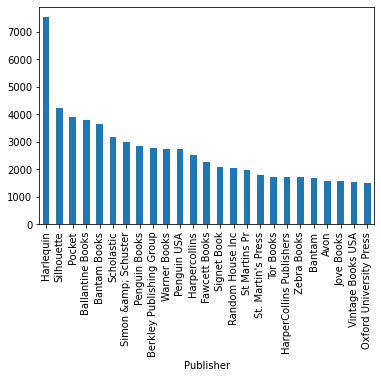

En promedio, una editorial ha publicado: 16.15 libros


In [ ]:
books_by_publisher = books.groupby(["Publisher"]).size()
books_by_publisher.sort_values(ascending=False).head(25).plot(y='size', kind="bar")
plt.show()
print("En promedio, una editorial ha publicado: " + str(round(books_by_publisher.mean(),2))+" libros")

<u>Autores con más libros</u>

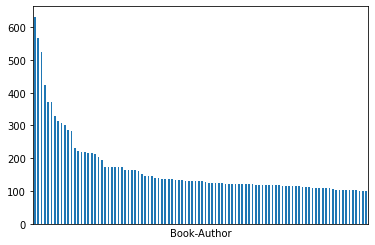

En promedio, un autor ha escrito: 2.66 libros


In [ ]:
books_by_author = books.groupby(["Book-Author"]).size()
books_by_author.sort_values(ascending=False).head(100).plot(xlabel="Book-Author",y='size', kind="bar")
plt.tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=False)
plt.show()
print("En promedio, un autor ha escrito: " + str(round(books_by_author.mean(),2))+" libros")

<u>Recapitulativo:</u>

In [ ]:
print("Total de libros: "+ str(books.shape[0]) + " libros \n")
print("Total libros con ratings: "+ str(reviews_count.shape[0])+" libros \n")
print("Total de usuarios: " + str(users.shape[0])+" usuarios \n")
print("Total ratings: " + str(ratings.shape[0])+ " ratings")

Total de libros: 271379 libros 

Total libros con ratings: 270172 libros 

Total de usuarios: 101420 usuarios 

Total ratings: 1031511 ratings


In [ ]:
print(str(round(reviews_count[reviews_count['size'].astype(float)>=centiles.iloc[0]['size']].sort_values(by=['size'],ascending=False).head(reviews_count[reviews_count['size'].astype(float)>=centiles.iloc[0]['size']].shape[0])['size'].sum()/ratings.shape[0]*100)) + "% de los ratings están alojados en 5% del total de los libros \n" )
print(str(reviews_count[reviews_count['size'].astype(float)>=centiles.iloc[0]['size']].shape[0])+" of "+ str(reviews_count.shape[0]) + " libros tienen más de " +str(int(centiles.iloc[0]['size']))+ " ratings \n")

47% de los ratings están alojados en 5% del total de los libros 

13845 of 270172 libros tienen más de 12 ratings 



#Sistema de recomendación

<u>Obtención de nearest neighbors</u>

In [ ]:
def neighbors(user_sim,pd_matrix,csr_matrix,nbrs):
  query_indexes = pd_matrix.reset_index()[pd_matrix.reset_index()[pd_matrix.reset_index().columns.values[0]].isin(user_sim)].index.values
  distances, indices = nbrs.kneighbors(csr_matrix[query_indexes])
  vecinos = np.array([pd_matrix.reset_index().iloc[x][pd_matrix.reset_index().columns.values[0]].values for x in [i for i in indices]])
  return (vecinos,distances)

<u>Tratamiento</u>

Eliminar usuarios inactivos (4 books calificados o menos) ~aprox. 75% <br>
Eliminar libros poco o muy populares (12 ratings o menos, 400 ratings o mas) ~aprox. 95%

In [ ]:
active_users = users[users.index.isin(users_by_rating[users_by_rating['size']>4]['User-ID'])]

active_books = books[books.index.isin(reviews_count[(reviews_count['size']>42) & (reviews_count['size']<400)]['ISBN'])]

active_ratings = ratings[ratings['User-ID'].isin(active_users.index)]
active_ratings = active_ratings[active_ratings['ISBN'].isin(active_books.index)]

In [ ]:
print("Usuarios activos: "+str(active_users.shape[0]))
print("Libros activos: "+str(active_books.shape[0]))
print("Ratings activos: "+str(active_ratings.shape[0]))

Usuarios activos: 19555
Libros activos: 222
Ratings activos: 14151


<u><b>User-User Collaborative filter</b></u>

<u>User-Item Matrix</u> <br>
También añado el país y la edad de cada usuario, ya que sirve para buscar similitudes entre ellos. <br>
Decidí quitar la ciudad y la region porque puede overfit el sistema.

In [ ]:
user_item_matrix = active_ratings.pivot_table(index="ISBN",columns="User-ID",values="Book-Rating")
user_age_country = users[users.index.isin(active_ratings['User-ID'])].drop(columns=["City","Region"])
user_age_country['Country'] = user_age_country['Country'].factorize()[0]
user_age_country['Country'] += 1
user_age_country = user_age_country.transpose()
user_item_matrix = pd.concat([user_age_country,user_item_matrix]).transpose().astype(float).fillna(-1)
csr_user_item_matrix = csr_matrix(user_item_matrix.values)
print(user_item_matrix)

          Age  Country  0028604199  ...  1573228214  1857022424  1931561648
User-ID                             ...                                    
165      62.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
243       0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
254      24.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
300       0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
383       0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
...       ...      ...         ...  ...         ...         ...         ...
278545    0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
278633    0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
278771    0.0      1.0        -1.0  ...        -1.0        -1.0        -1.0
278774   33.0      3.0        -1.0  ...        -1.0        -1.0        -1.0
278843   28.0      1.0        -1.0  ...        -1.0        -1.0        -1.0

[5293 rows 

<u><b>Item-Item Collaborative Filtering</b></u>

<u>Item-User Matrix</u> <br>
También añado el año de publicación, el autor y la editorial de cada libro, ya que sirve para buscar similitudes entre ellos. <br>

In [ ]:
item_user_matrix = active_ratings.pivot_table(index="User-ID",columns="ISBN",values="Book-Rating")
book_info = books[books.index.isin(active_ratings['ISBN'])].drop(columns=["Book-Title"])
book_info['Book-Author'] = book_info['Book-Author'].factorize()[0]
book_info['Book-Author'] += 1
book_info['Publisher'] = book_info['Publisher'].factorize()[0]
book_info['Publisher'] += 1
book_info = book_info.transpose()
item_user_matrix = pd.concat([book_info,item_user_matrix]).fillna(-1).astype(int).transpose()
csr_item_user_matrix = csr_matrix(item_user_matrix.values)
print(item_user_matrix)

            Book-Author  Year-Of-Publication  Publisher  ...  278771  278774  278843
0441783589            1                 1987          1  ...      -1      -1      -1
0061099325            2                 1992          2  ...      -1      -1      -1
0446601640            3                 1994          3  ...      -1      -1      -1
0449911004            4                 1996          4  ...      -1      -1      -1
0375719180            5                 2002          5  ...      -1      -1      -1
...                 ...                  ...        ...  ...     ...     ...     ...
0552999458          157                 2002         76  ...      -1      -1      -1
0553584375          158                 2003         18  ...      -1      -1      -1
0446354732            9                 1995          3  ...      -1      -1      -1
0553290789           11                 1999         18  ...      -1      -1      -1
0310205719          159                 2002         77  ...     

<u>Busqueda de K Nearest Neighbors</u>

<u>user-user</u>

In [ ]:
user_nbrs = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=15, n_jobs=-1).fit(csr_user_item_matrix)
nearest_neighbors,distances = neighbors([165,300],user_item_matrix,csr_user_item_matrix,user_nbrs)

print(nearest_neighbors)


[[   165 213350 166409  41634   3977  37046  91058 174152 241565 240401
  146890 136584  29867  24685 271398]
 [   300 190492 240906 231132  93312  60977  79366 193759 149661 108535
   25700 109082 105672  25131 106417]]


<u>item-item</u>

In [ ]:

item_nbrs = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=15, n_jobs=-1).fit(csr_item_user_matrix)
nearest_neighbors,distances = neighbors(["0061099325","0441783589"],item_user_matrix,csr_item_user_matrix,item_nbrs)

print(nearest_neighbors)


[['0441783589' '0446602213' '0446350109' '0312963009' '0446601640'
  '0345404777' '0446610178' '039914739X' '067103619X' '0061099325'
  '0446354732' '0440224829' '0553576925' '0553285785' '0553290789']
 ['0061099325' '0446350109' '0312963009' '0446602213' '0345404777'
  '0446601640' '067103619X' '0446354732' '0446610178' '039914739X'
  '0440224829' '0553290789' '0553576925' '0553285785' '0451184718']]
